# Test raw data classification with PCA

We use PCA to transform the raw data and use a classifier for classification. 
We run hyperparameter tuning on the number of PCA features. 

In [1]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from pathlib import PosixPath 
import glob
import os
import logging
import numpy as np
import matplotlib.pyplot as plt
import tqdm

from fastespy.ml import MLHyperParTuning
from fastespy import ml
from fastespy.analysis import init_logging
import sys
sys.path.append("/Users/manuelmeyer/Python/fastespy/fastespy/scripts/")
sys.path.append("/Users/manuelmeyer/Python/TESdata/fastespy/fastespy/scripts/")
from ml_intrinsic_bkg import load_data, run

In [2]:
%matplotlib inline

In [3]:
init_logging("INFO", color=True)

## Read data 

In [4]:
path = "/Users/manuelmeyer/Documents/TESData/IntrinsicsData_NewSetup/" # May 2021 data
prefix = "IntrinsicsData_NewSetup"

path = "/Users/manuelmeyer/Documents/TESData/August2020/" # August 2021 data
prefix = "August2020"

#path = "/Users/manuelmeyer/Python/TESdata/data-01152021//" # August 2020 data
#prefix = "data_august2020"

in_dir = PosixPath(path)
files = glob.glob(os.path.join(path, '*.npy'))

print(len(files))
#files

if not len(files):
    path = "/Users/manuelmeyer/Python/TESdata/data-05122021/"
    in_dir = PosixPath(path)
    files = glob.glob(os.path.join(path, '*.npy'))
    print(len(files))

17


In [5]:
files = list(in_dir.glob("*.npy"))

logging.info("Using files:")
for f in files:
    logging.info(f)

# define the feature names
feature_names = []
remove = ['data', 'time', 'pulse integral raw', 'voltage error',
          'error', 'start time in hrs', 'end time in hrs',
          'trigger time'
        ]

remove.append('constant')  # this seems to help

x = np.load(files[0], allow_pickle=True).tolist()
for k in x[1].keys():
    if not k in remove and not 'error' in k:
        feature_names.append(k)

logging.info("Using features names {}".format(feature_names))

 # define light cleaning cuts
light_cleaning_cuts = {
     "chi2 reduced": "chi2 < 6.",
    "decay time": "decay < 10.e-6",
    "trigger time": "(trigger >= 29.5e-6) & (trigger <= 30.8e-6)",  # from gaussian fit, 5 sigma interval
}

# read the data
result, data, t_tot_hrs = load_data(files, feature_names, light_cleaning_cuts=light_cleaning_cuts)

3753470350.py:   3 --- INFO: Using files:
3753470350.py:   5 --- INFO: /Users/manuelmeyer/Documents/TESData/August2020/0.3RN-1.5GHzGBWP-intrinsics-50MHz-20mV-1day-16-fit000.npy
3753470350.py:   5 --- INFO: /Users/manuelmeyer/Documents/TESData/August2020/0.3RN-1.5GHzGBWP-intrinsics-50MHz-20mV-72hrs-3-fit000.npy
3753470350.py:   5 --- INFO: /Users/manuelmeyer/Documents/TESData/August2020/0.3RN-1.5GHz-light-000-fit.npy
3753470350.py:   5 --- INFO: /Users/manuelmeyer/Documents/TESData/August2020/0.3RN-1.5GBWP-intrinsics-50MHz-20mV-1day-9-fit000.npy
3753470350.py:   5 --- INFO: /Users/manuelmeyer/Documents/TESData/August2020/0.3RN-1.5GHzGBWP-intrinsics-50MHz-20mV-1day-13-fit000.npy
3753470350.py:   5 --- INFO: /Users/manuelmeyer/Documents/TESData/August2020/0.3RN-1.5GHzGBWP-intrinsics-50MHz-20mV-1day-14-fit000.npy
3753470350.py:   5 --- INFO: /Users/manuelmeyer/Documents/TESData/August2020/0.3RN-1.5GHzGBWP-intrinsics-50MHz-20mV-72hrs-1-fit000.npy
3753470350.py:   5 --- INFO: /Users/manuelme

Convert raw data into machine learning format with samples and features

In [6]:
print (data['time'].shape)
print (data['data'].shape) # n samples x n features
print (result['type'].shape)  # n samples

(40646, 10000)
(40646, 10000)
(40646,)


In [7]:
downsample = 10 # use only every n-th data point / decrease sampling frequency by this amount
factor_x = 1e6  # seconds to micro seconds
factor_y = 1e3 # V to mV

In [8]:
X_raw = data['data'][:,::downsample] * factor_y
# size:
X_raw.shape

(40646, 1000)

In [9]:
y_raw = result['type']

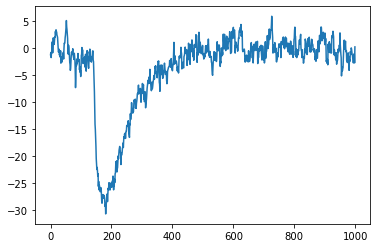

In [10]:
plt.plot(X_raw[0])

### build a sklearn pipeline

In [11]:
normalizer = StandardScaler()
pca = PCA()

default_rf={'n_estimators': 300,
            'max_features': 1,
            'min_samples_split': 2,
        }

clf = RandomForestClassifier(**default_rf)

In [12]:
pipe = Pipeline([('normalizer', normalizer), ('pca', pca), ('clf', clf)])

In [16]:
param_grid = dict(pca__n_components=np.arange(2,53,10))
print(param_grid)

{'pca__n_components': array([ 2, 12, 22, 32, 42, 52])}


In [ ]:
run(X_raw, y_raw, feature_names,
    classifier=pipe, 
    param_grid=param_grid,
    t_tot_hrs=t_tot_hrs,
    data=data,
    kfolds=5, 
    classifier_name="pipe_dt",
    out_dir=PosixPath("./"),
    random_state=42,
    log_data=False,
    use_pca=False,
    n_jobs=20)

ml_intrinsic_bkg.py: 239 --- INFO: Running optimization for split 1 / 5


Fitting 5 folds for each of 6 candidates, totalling 30 fits
The parameter search took 74.59 s
Profiling over parameters
Refitting on whole test data set and computing learning curve and confusion matrix
[learning_curve] Training set sizes: [ 3251  6503  9754 13006 16258 19509 22761 26012]


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  40 out of  40 | elapsed:   39.6s finished


[learning_curve] Training set sizes: [ 3251  6503  9754 13006 16258 19509 22761 26012]


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  40 out of  40 | elapsed:   28.2s finished


[learning_curve] Training set sizes: [ 3251  6503  9754 13006 16258 19509 22761 26012]


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  40 out of  40 | elapsed:   38.5s finished
ml_intrinsic_bkg.py: 161 --- INFO: Printing performance:
ml_intrinsic_bkg.py: 164 --- INFO: Running Feldman & Cousins confidence interval estimation for dark current


==== AUC : bkg_pred ====
train: 0.000e+00
test: 1.073e-05
==== AUC : tp_efficiency ====
train: 1.000e+00
test: 2.991e-01
==== AUC : score ====
train: 1.000e+00
test: 9.990e-01
==== AUC : Significance ====
train: 10.218
test: 1.602
==== Accuracy : bkg_pred ====
train: 0.000e+00
test: 2.413e-05
==== Accuracy : tp_efficiency ====
train: 1.000e+00
test: 7.430e-01
==== Accuracy : score ====
train: 1.000e+00
test: 9.921e-01
==== Accuracy : Significance ====
train: 10.218
test: 2.633
==== Significance : bkg_pred ====
train: 0.000e+00
test: 5.363e-06
==== Significance : tp_efficiency ====
train: 1.000e+00
test: 3.037e-01
==== Significance : score ====
train: 1.022e+01
test: 2.144e+00
==== Significance : Significance ====
train: 10.218
test: 2.144


/Users/manuelmeyer/Python/fastespy/fastespy/feldman_cousins.py:311: UserWarning: The given `mus`-array is probably to coarse. No upper limit found for `n_obs` = 2. Setting the upper limit to inf.
  warnings.warn(('The given `mus`-array is probably to coarse.' +
/Users/manuelmeyer/Python/fastespy/fastespy/feldman_cousins.py:311: UserWarning: The given `mus`-array is probably to coarse. No upper limit found for `n_obs` = 3. Setting the upper limit to inf.
  warnings.warn(('The given `mus`-array is probably to coarse.' +
/Users/manuelmeyer/Python/fastespy/fastespy/feldman_cousins.py:311: UserWarning: The given `mus`-array is probably to coarse. No upper limit found for `n_obs` = 4. Setting the upper limit to inf.
  warnings.warn(('The given `mus`-array is probably to coarse.' +
/Users/manuelmeyer/Python/fastespy/fastespy/feldman_cousins.py:311: UserWarning: The given `mus`-array is probably to coarse. No upper limit found for `n_obs` = 5. Setting the upper limit to inf.
  warnings.warn(('

Fitting 5 folds for each of 6 candidates, totalling 30 fits
The parameter search took 67.17 s
Profiling over parameters
Refitting on whole test data set and computing learning curve and confusion matrix
[learning_curve] Training set sizes: [ 3251  6503  9755 13006 16258 19510 22761 26013]


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  40 out of  40 | elapsed:   38.9s finished


[learning_curve] Training set sizes: [ 3251  6503  9755 13006 16258 19510 22761 26013]


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
